# MODAL MAP IP TE 

# Mehdi Zhioua, Arnaud Bienfait

In [2]:
import csv
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
from scipy import sparse
from scipy import stats
from scipy import optimize
from scipy.sparse.linalg import dsolve
from sklearn import linear_model
from IPython.display import Image
import random
from tqdm.notebook import tqdm
import os
from PIL import Image
import cv2


#premiers=[1]+eratosthene(1000)

alpha=0.95
eps=0.0001

**Format des données** 

- G est un graphe qui contient les villes, les arrêtes présentes entre chaque ville ainsi que les capacités des arrêtes 
- K est un graphe qui va contient les demandes entre chaque noeud 

**But 1 : coder un simulateur qui décide du routage de l'information sur le graphe**

- Tout d'abord il faut calculer les plus courts chemins le long desquels on va acheminer l'information. 
- Si plusieurs plus court chemins existent, mettons que l'on peut partir de l'arrête i vers j1 ou de l'arrête i vers j2 tout en restant sur un plus court chemin, on divise en deux le signal : la moitié sur j1 et l'autre sur j2. 
![title](Réseau.jpg)

- Il faut donc commencer par coder **une fonction plus court chemin** qui prend en argument le graphe G, et qui retourne  tous les plus courts chemin possibles.
- On code ensuite la fonction **traitement chemin** qui traite l'écoulement de l'information sur un couple (noeudA, nouedB) donné dans la matrice des demande
- La fonction **routage** qui itère la sous-routine traitement chemmin sur toute la matrice des demande

## 1. Lecture des fichiers et création des graphes G, K

In [3]:
#Lecture des CSV
G = nx.Graph()
pos = {}
site = {}
#  Noeuds avec Coordonnées, indices des noeuds, nom des villes
with open('nodes_cost266.csv', 'r') as f_node:
    reader = csv.DictReader(f_node, delimiter=';', quotechar="'")
    for row in reader:
        node = int(row['node'])
        site_node = row['site']
        x_coord = float(row['X'])
        y_coord = float(row['Y'])
        G.add_node(node,site=site_node)
        pos[node] = [x_coord,y_coord]
        site[node] = site_node
        
#  Edges avec extrémités et capacités
with open('edges_cost266.csv', 'r') as f_edge:
    reader = csv.DictReader(f_edge, delimiter=';', quotechar="'")
    for row in reader:
        nodeA = int(row['nodeA'])
        nodeB = int(row['nodeB'])
        G.add_edge(nodeA,nodeB)        
        G[nodeA][nodeB]['capa'] = float(row['capa'])
        G[nodeA][nodeB]['poids'] = 1


H = nx.DiGraph(G)
capa = {}

for (u,v) in G.edges():
    capa[(u,v)] = G[u][v]['capa']

#  Demandes avec extremités des arêtes
K = nx.DiGraph()

with open('demand_cost266.csv', 'r') as f_demand:
    reader = csv.DictReader(f_demand, delimiter=';', quotechar="'")
    for row in reader:
        nodeA = int(row['nodeA'])
        nodeB = int(row['nodeB'])
        if nodeA > nodeB:
            tmp = nodeA
            nodeA = nodeB
            nodeB = tmp
            
        K.add_edge(nodeA,nodeB)                    
        K[nodeA][nodeB]['demand'] = float(row['demand'])/25.0

#Initialisation de la table de routage 
routage=[]
for k in range(len(G.nodes())+1):
    routage.append([[],[]]) #[[sortants],[entrants]]

for nodeA in G.nodes():
    try:
      for e in K[nodeA]:
        routage[nodeA][0].append([nodeA,e,K[nodeA][e]['demand']])
    except:
      pass

## 2. Calcul des plus courts chemins

La fonction suivante renvoie une matrice permettant de savoir, pour tous (i,j,k) quels sont les prochains sommets où on le débit peut s'écouler à partir de k tout en restant sur un plus court chemin de i vers j. PCC(G) retourne une liste de liste de liste PCC telle que que PCC[i][j][k] contienne la liste des sommets suivants voulue
![title](PCC.jpg)

In [4]:
def PCC(Graph) :
    
    #initialisation 
    PCC = []
    for k in range(len(Graph.nodes())+1) :
        L=[]
        for k in range(len(Graph.nodes())+1) :
            l =[]
            for k in range(len(Graph.nodes())+1) :
                l.append([])
            L.append(l)
        PCC.append(L)
      
    #PCC[i][j][k] représente tous les noeuds vers lequels on peut aller en partant de k tout en restant 
    #sur un plus court chemin menant de i à j

    for node in Graph.nodes() :
        for nodeB in Graph.nodes() :
            if node!=nodeB :
                #on traite l'ensemble des chemins de node vers nodeB

                shortest=list(nx.all_shortest_paths(Graph,node,nodeB,'poids','dijkstra')) #calcul des plus courts chemins 

                for short in shortest:
                    for k in range(len(short)-1):
                        depart=short[k]
                        arrivee=short[k+1]
                        if not (arrivee in PCC[node][nodeB][depart]):
                            PCC[node][nodeB][depart].append(arrivee)
    
    return PCC

## 3. Calcul du routage 

Cette fonction permet d'écouler le traffic sur tous les plus courts chemins entre noeudA et noeudB. Elle prend en argument ces deux noeuds et une matrice de saturations (celle qui contient la valeur actuelle des débits sur les arrêtes) et met à jour cette matrice
![title](saturations.jpg)

In [5]:
def traitement_chemin(noeudA,noeudB,saturations,Kmat,Chemins):
    
    demande = Kmat[noeudA][noeudB]['demand']
    predecesseurs=[[noeudA,demande]]
                
    termine = ((len(predecesseurs)==1 and predecesseurs[0][0]==noeudB) or (len(predecesseurs)==0))
                  
    while (not termine) : #tant qu'on a pas fini de traiter les PCC de noeudA -> noeudB
                    
        #print("traitemnent de ", noeudA , noeudB)
        arretes={}               
                    
        for i in range(len(predecesseurs)):
                        
            noeud=predecesseurs[i][0]
            demande=predecesseurs[i][1]
            succ_noeud = Chemins[noeudA][noeudB][noeud]
                        
            for succ in succ_noeud:
                if not((noeud,succ) in arretes):
                    arretes[(noeud,succ)]=demande/len(succ_noeud)
                else:
                    arretes[(noeud,succ)]+=demande/len(succ_noeud)
        
        predecesseurs=[]
                    
                    
        for arrete in arretes:
            noeud1,noeud2=arrete
            charge = arretes[arrete]
            saturations[noeud1,noeud2]+=charge
            existant=False
            indice=0
            for i in range(len(predecesseurs)):
                if predecesseurs[i][0]==noeud2:
                    existant=True
                    indice=i
            if (not existant):
                predecesseurs.append([noeud2,charge])
            if existant:
                predecesseurs[indice][1]+=charge
                                      
        termine = ((len(predecesseurs)==1 and predecesseurs[0][0]==noeudB) or (len(predecesseurs)==0))

La fonction routage(G,K) initailise une matrice des saturations à 0, itère la sous-routine traitement_chemin sur toutes les paires noeudA, noeudB associées à une demande non nulle et remplit au fur et à mesure la matrice des saturations qui est renvoyée à la fin

visaulise(G,K,saturations) permet de dessiner le graphe avec sur chaque arrête la valeur du débit correspondant

In [6]:
def routage(Graph,Kmat):
    
    Chemins=PCC(Graph)
    
    #print("calcul du routage : ...")
    #print("[",end='')
    
    n=len(Graph.nodes())
    
    saturations=np.zeros((n+1,n+1))
    
    for noeudA in range(n+1):
        try:
            for noeudB in Kmat[noeudA]:
                traitement_chemin(noeudA,noeudB,saturations,Kmat,Chemins)
                
        except:
            pass
        
    #print("]"," calcul du routage terminé")
    #on symétrise la matrice des saturations
        
    transposee = np.zeros((n+1,n+1))
    for i in range(n+1):
        for j in range(n+1):
            transposee[i,j]=saturations[j,i]
            
    saturations=saturations+transposee
        
    return saturations

In [7]:
def visualise(Graph,Kmat,saturations):
    edge_lab={}
    for (u,v) in Graph.edges():
        edge_lab[(u,v)] = round(10*(saturations[v,u]))/10
    

    plt.figure(figsize=(15,10));
    plt.axis('off')

    nx.draw_networkx_labels(Graph,pos,font_size=10,font_color='black')
    nx.draw(Graph, pos=pos,node_size=500, node_color='lightgrey', edge_color='grey')

    nx.draw_networkx_labels(Kmat,pos,font_size=10,font_color='black')  
    nx.draw_networkx_nodes(Kmat, pos=pos, node_size=600, node_color='orange',node_shape='s')
    nx.draw_networkx_edge_labels(Graph,pos,edge_labels=edge_lab,font_color='red',font_size=10)
    print(edge_lab)

Afin de réaliser le calcul du routage, il suffit d'executer la cellule suivante 

{(1, 8): 5.3, (1, 19): 91.8, (1, 14): 188.4, (1, 15): 228.8, (2, 26): 13.6, (2, 36): 46.8, (2, 31): 9.6, (3, 30): 38.0, (3, 21): 4.4, (3, 22): 42.3, (4, 9): 14.5, (4, 36): 4.8, (4, 31): 9.6, (5, 24): 100.6, (5, 10): 0.0, (5, 35): 261.7, (5, 28): 9.1, (5, 15): 177.4, (6, 19): 33.7, (6, 14): 33.7, (7, 27): 24.5, (7, 21): 5.3, (7, 22): 29.9, (8, 27): 5.3, (8, 12): 0.0, (9, 17): 14.5, (9, 28): 0.0, (10, 32): 0.0, (10, 25): 0.0, (11, 19): 53.2, (11, 14): 58.3, (12, 13): 0.0, (13, 24): 88.3, (13, 33): 17.7, (13, 15): 115.5, (16, 32): 0.0, (16, 25): 0.0, (16, 35): 51.2, (17, 35): 14.5, (18, 19): 138.5, (18, 21): 9.7, (18, 30): 116.0, (19, 27): 61.5, (20, 27): 24.5, (20, 37): 0.0, (20, 22): 24.5, (22, 29): 96.7, (23, 24): 105.5, (23, 29): 105.5, (23, 37): 0.0, (24, 34): 19.2, (26, 29): 13.6, (27, 33): 17.7, (28, 34): 9.1, (29, 36): 13.6, (33, 37): 0.0, (34, 36): 28.3}


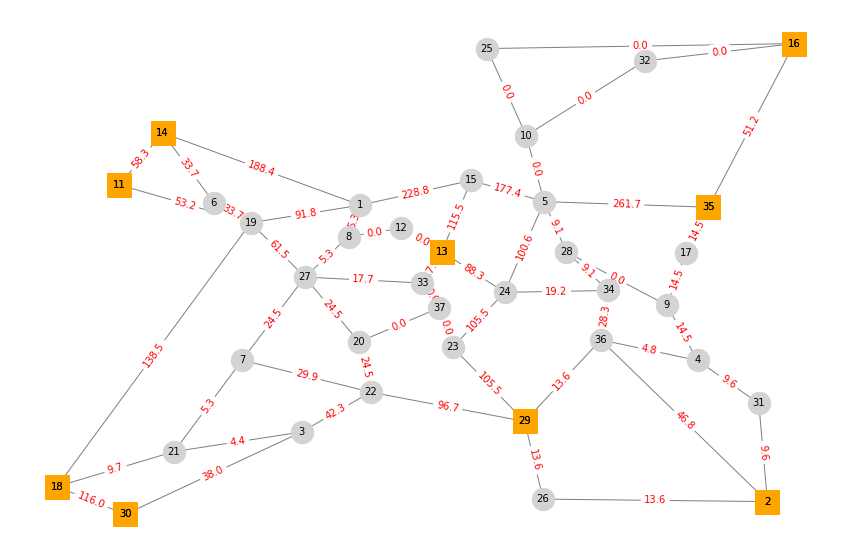

In [8]:
mat=routage(G,K)
visualise(G,K,mat)

## 4. Optimisation des métriques : incrémentation des poids des arrêtes maximales

**But 2 : modifier les poids des arrêtes pour faire dimininuer la charge des arrêtes les plus saturées**

- La première heuristique que l'on peut envisager pour optimiser les métriques est de sélectionner l'arrête la plus chargée et d'en augmenter le poids afin que les calculs de plus court chemins aient tendance à d'avantage "contourner l'arrête".

- Par la suite, on envisagera des méthodes de type descente de gradient et recuit simulé

![title](methode_incrementale.jpg)

### Quelques petites fonctions intermédiaires 

Les cellules suivantes constituent une liste de fonctions utiles pour la suite :
cout_routage permet de calculer le rapport entre charge/charge_maximale. C'est justement le maximum de ces rapports que l'on va chercher à minimiser. Idéalement, on veut que pour toute arrête, charge/charge_maximale < 1

In [9]:
def cout_routage(Matrice,Graph,condition=False):
    n=len(Graph.nodes())-condition
    for i in range(1,n+1):
        for j in Graph[i] :
            if i<j:
                Matrice[i][j]=Matrice[i][j]/Graph[i][j]['capa']
                Matrice[j][i]=Matrice[j][i]/Graph[i][j]['capa']
    return Matrice

mise_a_jour_poids permet de mettre à jour les poids des arrêtes en fonction d'une matrice de poids donnée en entrée

In [10]:
def mise_a_jour_poids(poids,Graph):
    n=len(Graph.nodes())
    for i in Graph:
        for j in Graph[i] :
            Graph[i][j]['poids']=poids[i][j]

La fonction init_poids permet de réinitialiser tous les poids des arrêtes à 1

In [11]:
def init_poids(Graph):
    for i in Graph:
        for j in Graph[i]:
            Graph[i][j]['poids']=1

init_poids(G)

l'exécution de visualise_changements(sat1,sat2,G) permet de visualiser les arrêtes dont les saturations ont changé

In [15]:
def visualise_changements(sat1,sat2,Graph):
    for i in Graph:
        for j in Graph[i]:
            if i<j:
                ancien=round(100*sat1[i,j])/100
                nouveau=round(100*sat2[i,j])/100
                borne=alpha*Graph[i][j]['capa']
                if (ancien != nouveau):
                    print("arrête",(i,j)," : ",ancien," --> ",nouveau," / ",borne)

La fonction modification_maximum sélectionne l'arrête la plus saturée de la matrice des saturations et incrémente son poids de 1

In [12]:
def modification_maximum(Graph,Kmat,sat):
    ind_max=np.unravel_index(np.argmax(sat, axis=None), sat.shape)
    imax=ind_max[0]
    jmax=ind_max[1]
    Graph[imax][jmax]['poids']+=1

Les deux cellules suivantes implémentent l'algorithme d'incrémentation du pois des arrêtes surchargées

In [13]:
init_poids(G)
liste_max=[]
for k in tqdm(range(20)):
    sat=cout_routage(routage(G,K),G)
    ind_max=np.unravel_index(np.argmax(sat, axis=None), sat.shape)
    imax=ind_max[0]
    jmax=ind_max[1]
    liste_max.append(sat[imax][jmax])
    modification_maximum(G,K,sat)

Text(0, 0.5, 'Valeur du maximum')

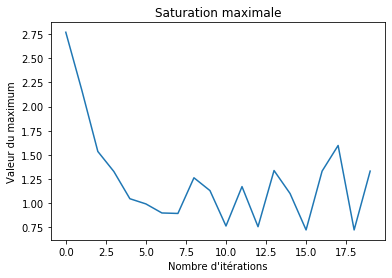

In [14]:
plt.plot([k for k in range(20)],liste_max)
plt.title("Saturation maximale")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Valeur du maximum")

Ces oscillations traduisent des phénomènes de basculement entre plusieurs chemins
![title](basculement.jpg)

In [16]:
def convergence(l,cible):
    j0 = 0
    while(l[j0]>cible):
        j0+=1
    return j0


Minimum trouvé :  0.7241866666666668


(0.7241866666666668, 14)

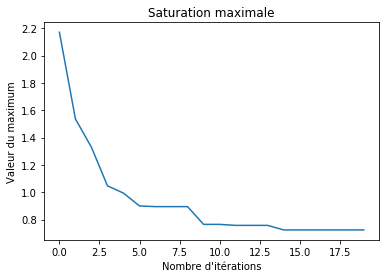

In [17]:
def methode_incrementale_selection_minimum(n,trace,Graph,Kmat,condition=False):
    
    liste_max=[]
    init_poids(Graph)
    sat1=cout_routage(routage(Graph,Kmat),Graph,condition)
    ind_max=np.unravel_index(np.argmax(sat1, axis=None), sat1.shape)
    i1=ind_max[0]
    j1=ind_max[1]
    J1=sat1[i1][j1] #J1 va contenir le minimum global
    sat2=sat1
    
    for k in tqdm(range(n)):
        modification_maximum(Graph,Kmat,sat2)
        sat2=cout_routage(routage(Graph,Kmat),Graph,condition)
        ind_max=np.unravel_index(np.argmax(sat2, axis=None), sat2.shape)
        i2=ind_max[0]
        j2=ind_max[1]
        J2=sat2[i2][j2]
        if (J1<J2):
            liste_max.append(J1)
        else:
            liste_max.append(J2)
            J1=J2
            
    print("Minimum trouvé : ",J1)
    
    if trace:
        plt.plot([k for k in range(n)],liste_max)
        plt.title("Saturation maximale")
        plt.xlabel("Nombre d'itérations")
        plt.ylabel("Valeur du maximum")
        
    return J1, convergence(liste_max,J1)

methode_incrementale_selection_minimum(20,True,G,K)

## 5. Optimisation des métriques : descente de gradient, recuit simulé

### 5.1 Descente de gradient

Une autre piste permettant de minimiser une fonction objectif est celle de la descente de gradient classique. Malheuresement, cette méthode s'est révélée infructueuse à cause de l'allure assez "plate", rendant l'utilisation d'un gradient peu pertinent (il vaut 0 presque partout)

In [15]:
def J(poids,K):
    mise_a_jour_poids(poids,G)
    Matri = routage(G,K)
    return np.max(Matri)

In [16]:
def dJ(poids,K):
    n=len(G.nodes())
    Matr=np.zeros((n+1,n+1))
    for i in G :
        for j in G[i] :
            if i<j :
                h = 0.01
                poidsbis = poids.copy()
                poidsbis[i][j]+=h
                deriv = (J(poidsbis,K)-J(poids,K))/h
                Matr[i][j] = deriv
    return Matr

In [17]:
def descente_gradient(K, maxiter, pas = 1e-01):
    n=len(G.nodes())
    poids = np.zeros((n+1,n+1))
    for i in range(1,n+1):
        for j in G[i] :
            poids[i][j]=G[i][j]['poids']
    
    poids = poids.copy()
    poidstab =[]
    Jtab =[]
    poidstab.append(poids)
    
    it = 0
    
    while ((it==0) or (it < maxiter and np.linalg.norm(dJ(poidstab[-1],K))>1e-06)) :
        poids = poids - pas*dJ(poids,K)
        print("itération",it,"ok")
        poidstab.append(poids)
        
        it=it+1
    
    if (it==maxiter) or (np.isnan(np.linalg.norm(poids))==True) :
        conv = False
    else :
        conv = True
    mise_a_jour_poids(poids,G)
                
    return poidstab, Jtab, conv

### 5.2 Recuit simulé

On peut envisager ausis la piste du recuit simulé pour minimiser notre fonction objectif.
L'idée est de partir d'une matrice des poids dont tous les coefficients valent 1 et de chercher un autre état aléatoirement dans son voisinnage. On dit qu'une autre matrice des poids $p'$ et voisinne de $p$ s'il existe au plus un couple $(i_0,j_0)$ tel que $p(i_0,j_0) \neq p'(i_0,j_0)$ et $| p(i_0,j_0) - p'(i_0,j_0) | = 1$

![title](recuit.jpg)

In [18]:
def T(i) :
    return 300*((i+1)**(-0.03))

def proposition_poids(poids,Graph):
    n=len(Graph.nodes())
    poids = np.zeros((n+1,n+1))
    for i in range(1,n+1):
        for j in Graph[i] :
            if i<j:
                poids[i][j]=np.random.randint(1,10)
    
    transposee = np.zeros((n+1,n+1))
    for i in range(n+1):
        for j in range(n+1):
            transposee[i,j]=poids[j,i]
            
    poids=poids+transposee
    
    return poids

def poids_voisinage(poids,Graph):
    poidsbis = poids.copy()
    n = len(Graph.nodes())
    change = False 
    while (not change):
        i = np.random.randint(1,n)
        j = np.random.randint(1,n)
        if (i<j and poids[i][j]>0):
            poidsbis[i][j]+=1
            poidsbis[j][i]+=1
            change = True
    return poidsbis
    

def cout(poids,Graph,Kmat):
    mise_a_jour_poids(poids,Graph)
    Matrice = routage(Graph,Kmat)
    n=len(Graph.nodes())
    for i in range(1,n+1):
        for j in Graph[i] :
            if i<j:
                Matrice[i][j]=Matrice[i][j]/Graph[i][j]['capa']
                Matrice[j][i]=Matrice[j][i]/Graph[i][j]['capa']
    return np.max(Matrice)

In [19]:
def recuit(Graph,Kmat,poids_init, N_iter, proposition_poids, T) :
    poids = poids_init
    best = poids_init
    j=cout(poids,Graph,Kmat)
    coutseq = [j]
    coutbest = [j]
    for n in tqdm(range(N_iter), ascii=True, unit='n'):
        prop = poids_voisinage(best,Graph)
        U =np.random.rand()
        cout_prop=cout(prop,Graph,Kmat)
        cout_poids=coutseq[-1]
        cout_best=coutbest[-1]
        if U <= min(1,np.exp(-(cout_prop-cout_poids)/(T(n)))):
            poids = prop
            cout_poids=cout_prop
        if cout_poids<=cout_best:
            best = poids
            cout_best=cout_poids
        coutseq.append(cout(poids,Graph,Kmat))
        coutbest.append(cout_best)
        
    print("valeur du minimum",cout(best,Graph,Kmat))
    return poids, best, coutseq, coutbest

L'exécution de la cellule suivante permet de visualiser l'execution du recuit sur N_iter itérations

In [20]:
def plot_recuit(cseq, bseq, best, legend=True, label=""):
    p2, = plt.plot(cseq, label='cout(X_n) '+label)
    p3, = plt.plot(bseq, label='cout(Best_n) '+label)
    if legend:
        plt.legend(fontsize=12)
        plt.ylabel("Fonction objectif", fontsize=12)
        plt.xlabel("Nombre d'itérations", fontsize=12)


valeur du minimum 1.229025


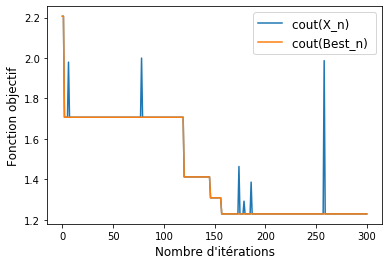

In [21]:
Graph=G
Kmat=K
init_poids(Graph)
N_iter = 300
n = len(Graph.nodes())
poids = np.zeros((n+1,n+1))
for i in range(n):
    for j in range(n):
        poids[i][j]=1
tour, best, cseq, bseq = recuit(Graph, Kmat,poids, N_iter,poids_voisinage, T)
plot_recuit(cseq, bseq, best)

## 6. Test sur des petites instances

On teste notre méthode de recherche du minimum sur de petites instances afin d'en vérifier la robustesse dans le cas où le minimum est connu : 
![title](petites.jpg)


Minimum trouvé :  1.3333333333333335


(1.3333333333333335, 2)

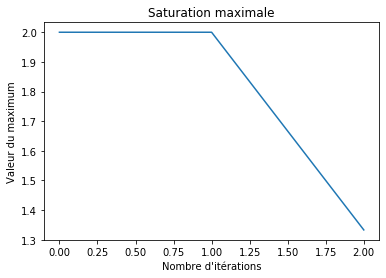

In [106]:
#Création de l'instance
G0 = nx.Graph()
G0.add_nodes_from([1,2,3,4,5,6,7,8])
G0.add_edges_from([(1, 2), (2, 3),(1,4),(4,5),(5,3),(1,6),(6,7),(7,8),(8,3)])
K0 = nx.DiGraph()

#Initialisation du graphe et de la demande 
for e1 in G0:
    for e2 in G0[e1]:
        G0[e1][e2]['capa']=25
        G0[e1][e2]['poids']=1

K0.add_edge(1,3)
K0[1][3]['demand']=100.0
methode_incrementale_selection_minimum(3,True,G0,K0,False)


Minimum trouvé :  1.0


(1.0, 5)

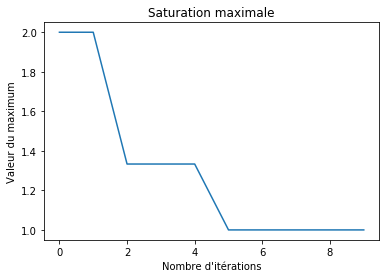

In [107]:
#Création de l'instance
G1 = nx.Graph()
G1.add_nodes_from([1,2,3,4,5,6,7,8,9,10,11,12])
G1.add_edges_from([(1, 2), (2, 3),(1,4),(4,5),(5,3),(1,6),(6,7),(7,8),(8,3),(1,9),(9,10),(10,11),(11,12),(12,3)])
K1 = nx.DiGraph()

#Initialisation du graphe et de la demande 
for e1 in G1:
    for e2 in G1[e1]:
        G1[e1][e2]['capa']=25
        G1[e1][e2]['poids']=1

K1.add_edge(1,3)
K1[1][3]['demand']=100.0
methode_incrementale_selection_minimum(10,True,G1,K1,False)

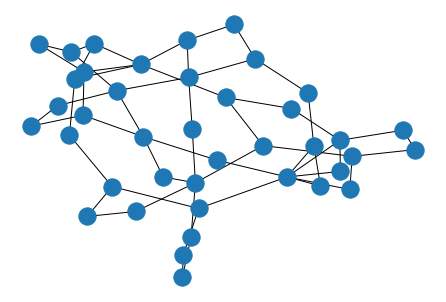

In [99]:
def generation_instance_aleatoire(n,trace=False):
    Gp = nx.gnm_random_graph(n,n, seed = None, directed = False)

    for na in Gp : 
        for nb in Gp :
            if nb not in nx.algorithms.descendants(Gp, na) :
                Gp.add_edge(na,nb)
            if len(Gp[na])==1 : 
                n = (int)(np.random.random()*30)
                if n != na :
                    Gp.add_edge(na, n)
    for na in Gp :
        for nb in Gp[na] :
            Gp[na][nb]['poids'] = 1
            Gp[na][nb]['capa'] = 200
        
    if trace:
        nx.draw(Gp)
        
    Kp = nx.DiGraph()

    for na in Gp :
        for nb in Gp[na] :
            if np.random.random()<0.06 :
                Kp.add_edge(na,nb) 
                Kp[na][nb]['demand'] = (int)(np.random.exponential(1)*100)
                
    return Gp,Kp
            
Gp,Kp=generation_instance_aleatoire(40,True)


Minimum trouvé :  5.285714285714286


15

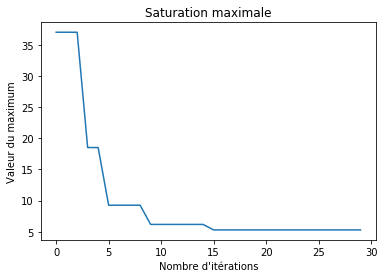

In [96]:
methode_incrementale_selection_minimum(30, True, Gp, Kp,True)

In [117]:
convergences=[]
valeurs_min=[]
for n in tqdm(range(40,80)):
    a=0
    for k in range(10):
        Gn,Kn=generation_instance_aleatoire(n,False)
        J,ak=methode_incrementale_selection_minimum(n,False,Gn,Kn,True)
        a+=ak
    convergences.append(a/10)
    valeurs_min.append(J)


Minimum trouvé :  0.7475



Minimum trouvé :  45.5



Minimum trouvé :  46.5



Minimum trouvé :  50.0



Minimum trouvé :  4.666666666666667



Minimum trouvé :  1.1666666666666667



Minimum trouvé :  36.333333333333336



Minimum trouvé :  37.75



Minimum trouvé :  2.5714285714285716



Minimum trouvé :  1.3



Minimum trouvé :  2.142857142857143



Minimum trouvé :  0.9



Minimum trouvé :  0.31



Minimum trouvé :  6.857142857142857



Minimum trouvé :  55.0



Minimum trouvé :  28.0



Minimum trouvé :  0.5



Minimum trouvé :  1.11



Minimum trouvé :  36.6



Minimum trouvé :  12.0



Minimum trouvé :  20.666666666666668



Minimum trouvé :  22.3125



Minimum trouvé :  46.0



Minimum trouvé :  5.666666666666667



Minimum trouvé :  17.0



Minimum trouvé :  0.6375



Minimum trouvé :  6.714285714285714



Minimum trouvé :  1.585



Minimum trouvé :  24.333333333333332



Minimum trouvé :  14.428571428571429



Minimum trouvé :  0.7



Minimum trouvé :  0.37708333333333327



Minimum trouvé :  0.36



Minimum trouvé :  3.5



Minimum trouvé :  25.333333333333332



Minimum trouvé :  32.5



Minimum trouvé :  0.64



Minimum trouvé :  0.32



Minimum trouvé :  20.333333333333332



Minimum trouvé :  0.4775



Minimum trouvé :  1.0475



Minimum trouvé :  1.355



Minimum trouvé :  0.22666666666666666



Minimum trouvé :  0.7608333333333333



Minimum trouvé :  86.625



Minimum trouvé :  2.9



Minimum trouvé :  37.41666666666667



Minimum trouvé :  49.25



Minimum trouvé :  31.636363636363637



Minimum trouvé :  26.0



Minimum trouvé :  32.708333333333336



Minimum trouvé :  1.855



Minimum trouvé :  29.916666666666668



Minimum trouvé :  0.605



Minimum trouvé :  1.355



Minimum trouvé :  75.71428571428571



Minimum trouvé :  89.0



Minimum trouvé :  23.0



Minimum trouvé :  9.222222222222221



Minimum trouvé :  5.0625



Minimum trouvé :  0.9925



Minimum trouvé :  1.355



Minimum trouvé :  20.375



Minimum trouvé :  6.88888888888889



Minimum trouvé :  18.0



Minimum trouvé :  1.65



Minimum trouvé :  8.777777777777779



Minimum trouvé :  1.6



Minimum trouvé :  0.915



Minimum trouvé :  5.333333333333333



Minimum trouvé :  1.735



Minimum trouvé :  10.0



Minimum trouvé :  0.49333333333333335



Minimum trouvé :  9.5



Minimum trouvé :  2.0



Minimum trouvé :  45.625



Minimum trouvé :  1.0425



Minimum trouvé :  39.5



Minimum trouvé :  1.235



Minimum trouvé :  3.125



Minimum trouvé :  0.5075



Minimum trouvé :  6.2



Minimum trouvé :  46.0



Minimum trouvé :  1.2675



Minimum trouvé :  8.333333333333334



Minimum trouvé :  0.44



Minimum trouvé :  78.25



Minimum trouvé :  3.875



Minimum trouvé :  3.7777777777777777



Minimum trouvé :  170.5



Minimum trouvé :  9.0



Minimum trouvé :  0.66



Minimum trouvé :  14.428571428571429



Minimum trouvé :  1.64



Minimum trouvé :  1.72



Minimum trouvé :  0.34



Minimum trouvé :  8.25



Minimum trouvé :  81.66666666666667



Minimum trouvé :  0.7



Minimum trouvé :  32.0



Minimum trouvé :  1.4775



Minimum trouvé :  9.909090909090908



Minimum trouvé :  18.875



Minimum trouvé :  40.92307692307692



Minimum trouvé :  11.5



Minimum trouvé :  3.2



Minimum trouvé :  27.666666666666668



Minimum trouvé :  0.255



Minimum trouvé :  29.75



Minimum trouvé :  1.85



Minimum trouvé :  10.555555555555555



Minimum trouvé :  28.666666666666668



Minimum trouvé :  23.6



Minimum trouvé :  11.714285714285715



Minimum trouvé :  0.6325



Minimum trouvé :  4.769230769230769



Minimum trouvé :  13.777777777777779



Minimum trouvé :  4.0



Minimum trouvé :  48.0



Minimum trouvé :  1.05



Minimum trouvé :  2.475



Minimum trouvé :  13.15



Minimum trouvé :  1.555



Minimum trouvé :  2.0



Minimum trouvé :  14.0



Minimum trouvé :  47.5



Minimum trouvé :  0.85



Minimum trouvé :  1.0



Minimum trouvé :  42.125



Minimum trouvé :  33.25



Minimum trouvé :  11.5



Minimum trouvé :  25.2



Minimum trouvé :  21.0



Minimum trouvé :  11.8



Minimum trouvé :  0.855



Minimum trouvé :  0.81



Minimum trouvé :  63.666666666666664



Minimum trouvé :  0.305



Minimum trouvé :  1.095



Minimum trouvé :  6.909090909090909



Minimum trouvé :  0.39



Minimum trouvé :  87.66666666666667



Minimum trouvé :  1.25



Minimum trouvé :  0.835



Minimum trouvé :  39.5



Minimum trouvé :  1.9375



Minimum trouvé :  1.39



Minimum trouvé :  64.5



Minimum trouvé :  22.5



Minimum trouvé :  0.6925



Minimum trouvé :  62.0



Minimum trouvé :  1.88



Minimum trouvé :  4.25



Minimum trouvé :  47.70833333333333



Minimum trouvé :  0.4



Minimum trouvé :  12.833333333333334



Minimum trouvé :  28.0



Minimum trouvé :  1.9



Minimum trouvé :  27.5



Minimum trouvé :  14.7



Minimum trouvé :  3.75



Minimum trouvé :  0.1425



Minimum trouvé :  28.75



Minimum trouvé :  85.0



Minimum trouvé :  15.416666666666668



Minimum trouvé :  21.75



Minimum trouvé :  5.0625



Minimum trouvé :  0.75



Minimum trouvé :  14.9



Minimum trouvé :  28.166666666666668



Minimum trouvé :  0.71



Minimum trouvé :  37.41666666666667



Minimum trouvé :  23.5



Minimum trouvé :  58.6



Minimum trouvé :  5.8



Minimum trouvé :  0.415



Minimum trouvé :  42.666666666666664



Minimum trouvé :  0.765



Minimum trouvé :  117.5



Minimum trouvé :  11.454545454545455



Minimum trouvé :  80.56818181818181



Minimum trouvé :  33.0



Minimum trouvé :  1.0769230769230769



Minimum trouvé :  32.0



Minimum trouvé :  36.0



Minimum trouvé :  11.777777777777779



Minimum trouvé :  17.615384615384617



Minimum trouvé :  27.142857142857142



Minimum trouvé :  64.48611111111111



Minimum trouvé :  17.625



Minimum trouvé :  6.375



Minimum trouvé :  10.0



Minimum trouvé :  24.0



Minimum trouvé :  88.85714285714286



Minimum trouvé :  8.88888888888889



Minimum trouvé :  9.071428571428571



Minimum trouvé :  20.77777777777778



Minimum trouvé :  23.666666666666668



Minimum trouvé :  0.5875



Minimum trouvé :  14.0



Minimum trouvé :  43.75



Minimum trouvé :  1.505



Minimum trouvé :  29.0



Minimum trouvé :  0.7875



Minimum trouvé :  34.75



Minimum trouvé :  17.333333333333332



Minimum trouvé :  0.3325



Minimum trouvé :  0.89375



Minimum trouvé :  108.66666666666667



Minimum trouvé :  7.0



Minimum trouvé :  12.5



Minimum trouvé :  10.272727272727273



Minimum trouvé :  6.909090909090909



Minimum trouvé :  2.6666666666666665



Minimum trouvé :  1.03125



Minimum trouvé :  0.46



Minimum trouvé :  43.75



Minimum trouvé :  11.777777777777779



Minimum trouvé :  0.9225



Minimum trouvé :  11.0



Minimum trouvé :  5.714285714285714



Minimum trouvé :  0.5



Minimum trouvé :  63.75



Minimum trouvé :  21.0



Minimum trouvé :  106.66666666666667



Minimum trouvé :  4.0



Minimum trouvé :  0.97



Minimum trouvé :  5.875



Minimum trouvé :  30.0



Minimum trouvé :  1.39



Minimum trouvé :  53.5



Minimum trouvé :  8.571428571428571



Minimum trouvé :  7.384615384615385



Minimum trouvé :  1.3119444444444446



Minimum trouvé :  0.9025



Minimum trouvé :  40.75



Minimum trouvé :  20.625



Minimum trouvé :  0.4075



Minimum trouvé :  0.775



Minimum trouvé :  0.9525



Minimum trouvé :  19.791666666666668



Minimum trouvé :  24.666666666666668



Minimum trouvé :  43.0



Minimum trouvé :  1.4766666666666666



Minimum trouvé :  0.4975



Minimum trouvé :  0.975



Minimum trouvé :  20.5



Minimum trouvé :  1.515



Minimum trouvé :  23.0



Minimum trouvé :  1.065



Minimum trouvé :  18.714285714285715



Minimum trouvé :  0.965



Minimum trouvé :  17.833333333333332



Minimum trouvé :  10.25



Minimum trouvé :  1.575



Minimum trouvé :  18.45



Minimum trouvé :  71.25



Minimum trouvé :  6.545454545454546



Minimum trouvé :  3.6666666666666665



Minimum trouvé :  0.9383333333333332



Minimum trouvé :  44.5



Minimum trouvé :  0.5075



Minimum trouvé :  50.0



Minimum trouvé :  1.305



Minimum trouvé :  0.8



Minimum trouvé :  9.222222222222221



Minimum trouvé :  0.735



Minimum trouvé :  55.5625



Minimum trouvé :  44.41666666666667



Minimum trouvé :  0.99



Minimum trouvé :  0.53



Minimum trouvé :  9.333333333333334



Minimum trouvé :  5.666666666666667



Minimum trouvé :  0.6666666666666666



Minimum trouvé :  1.0



Minimum trouvé :  37.45535714285714



Minimum trouvé :  6.666666666666667



Minimum trouvé :  42.0



Minimum trouvé :  18.0



Minimum trouvé :  36.0



Minimum trouvé :  0.75



Minimum trouvé :  0.95



Minimum trouvé :  18.75



Minimum trouvé :  30.333333333333332



Minimum trouvé :  1.09



Minimum trouvé :  0.5



Minimum trouvé :  0.3075



Minimum trouvé :  57.0



Minimum trouvé :  0.955



Minimum trouvé :  20.833333333333332



Minimum trouvé :  3.8333333333333335



Minimum trouvé :  1.135



Minimum trouvé :  8.616666666666667



Minimum trouvé :  7.25



Minimum trouvé :  31.6



Minimum trouvé :  0.7825



Minimum trouvé :  26.5



Minimum trouvé :  9.333333333333334



Minimum trouvé :  23.833333333333332



Minimum trouvé :  1.27



Minimum trouvé :  88.41666666666667



Minimum trouvé :  10.0



Minimum trouvé :  14.583333333333332



Minimum trouvé :  109.25



Minimum trouvé :  1.63



Minimum trouvé :  23.285714285714285



Minimum trouvé :  3.6666666666666665



Minimum trouvé :  4.294117647058823



Minimum trouvé :  13.714285714285714



Minimum trouvé :  0.72



Minimum trouvé :  2.05



Minimum trouvé :  2.6



Minimum trouvé :  59.75



Minimum trouvé :  16.71875



Minimum trouvé :  7.583333333333333



Minimum trouvé :  9.4375



Minimum trouvé :  1.75



Minimum trouvé :  34.333333333333336



Minimum trouvé :  3.1666666666666665



Minimum trouvé :  14.677083333333336



Minimum trouvé :  0.58



Minimum trouvé :  0.97



Minimum trouvé :  0.98



Minimum trouvé :  9.404761904761905



Minimum trouvé :  21.25



Minimum trouvé :  14.5



Minimum trouvé :  7.0



Minimum trouvé :  34.666666666666664



Minimum trouvé :  20.5



Minimum trouvé :  56.5



Minimum trouvé :  49.0



Minimum trouvé :  64.45833333333334



Minimum trouvé :  0.74



Minimum trouvé :  21.09090909090909



Minimum trouvé :  5.214285714285714



Minimum trouvé :  36.75



Minimum trouvé :  6.518518518518518



Minimum trouvé :  3.2916666666666665



Minimum trouvé :  23.111111111111107



Minimum trouvé :  40.125



Minimum trouvé :  23.166666666666668



Minimum trouvé :  3.3333333333333335



Minimum trouvé :  24.0



Minimum trouvé :  2.933333333333333



Minimum trouvé :  0.985



Minimum trouvé :  16.333333333333332



Minimum trouvé :  13.0



Minimum trouvé :  30.5



Minimum trouvé :  10.5



Minimum trouvé :  79.0



Minimum trouvé :  1.4713333333333336



Minimum trouvé :  10.333333333333334



Minimum trouvé :  44.599999999999994



Minimum trouvé :  1.2857142857142858



Minimum trouvé :  1.06875



Minimum trouvé :  18.05



Minimum trouvé :  23.945454545454545



Minimum trouvé :  2.875



Minimum trouvé :  2.655



Minimum trouvé :  37.5



Minimum trouvé :  14.222222222222221



Minimum trouvé :  115.25



Minimum trouvé :  19.81818181818182



Minimum trouvé :  13.5



Minimum trouvé :  90.25



Minimum trouvé :  25.625



Minimum trouvé :  4.555555555555555



Minimum trouvé :  16.923076923076923



Minimum trouvé :  31.96666666666667



Minimum trouvé :  0.9422222222222223



Minimum trouvé :  1.41


KeyboardInterrupt: 

Text(0, 0.5, "Nombre d'itérations")

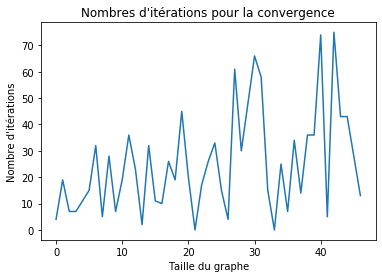

In [128]:
conv = [4, 19, 7, 7, 11, 15, 32, 5, 28, 7, 19, 36, 23, 2, 32, 11, 10, 26, 19, 45, 20, 0, 17, 26, 33, 15, 4, 61, 30, 48, 66, 58, 15, 0, 25, 7, 34, 14, 36, 36, 74, 5, 75, 43, 43, 28, 13]
val_min = [177.0, 35.333333333333336, 0.2175, 0.46, 11.0, 2.25, 46.666666666666664, 2.25, 61.55555555555556, 77.75, 34.0, 28.5, 3.125, 0.465, 5.777777777777778, 4.5, 14.0, 7.777777777777778, 0.67, 7.454545454545454, 0.5225, 2.185, 18.555555555555557, 18.8, 12.5, 106.25, 1.425, 60.58333333333333, 46.0, 31.5, 10.25, 38.5, 17.0, 0.535, 39.333333333333336, 1.605, 5.583333333333333, 24.25, 41.166666666666664, 5.0, 14.833333333333334, 123.5, 31.083333333333332, 9.384615384615385, 67.63333333333333, 33.47222222222222, 35.25]

plt.plot([k for k in range(len(conv))],conv)
plt.title("Nombres d'itérations pour la convergence")
plt.xlabel("Taille du graphe")
plt.ylabel("Nombre d'itérations")

0.5799668089141775 -10.28672356567094


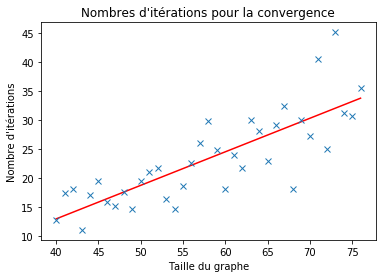

In [133]:
convergences=[12.7, 17.4, 18.0, 11.0, 17.1, 19.4, 15.8, 15.2, 17.6, 14.7, 19.4, 21.0, 21.7, 16.4, 14.7, 18.6, 22.5, 26.0, 29.9, 24.8, 18.1, 24.0, 21.7, 30.0, 28.1, 22.9, 29.2, 32.4, 18.1, 30.1, 27.2, 40.5, 25.0, 45.2, 31.3, 30.7, 35.6]
valeurs_min=[1.3, 12.0, 14.428571428571429, 0.4775, 26.0, 5.0625, 5.333333333333333, 3.125, 170.5, 32.0, 1.85, 1.05, 33.25, 6.909090909090909, 0.6925, 14.7, 28.166666666666668, 11.454545454545455, 17.625, 14.0, 7.0, 11.0, 1.39, 0.9525, 1.065, 0.9383333333333332, 0.99, 36.0, 20.833333333333332, 1.27, 0.72, 14.677083333333336, 56.5, 40.125, 79.0, 37.5, 0.9422222222222223]

X=np.array([k+40 for k in range(len(convergences))])

slope, intercept, r_value, p_value, std_err = stats.linregress(X,convergences)

def predict(x):
   return slope * x + intercept
fitLine = predict(X)
plt.plot(X, fitLine, c='r')
plt.plot(X,convergences,'x')
plt.title("Nombres d'itérations pour la convergence")
plt.xlabel("Taille du graphe")
plt.ylabel("Nombre d'itérations")
print(slope,intercept)

## 7. Modification des capacités

In [42]:
def init_capa():
    with open('edges_cost266.csv', 'r') as f_edge:
        reader = csv.DictReader(f_edge, delimiter=';', quotechar="'")
        for row in reader:
            nodeA = int(row['nodeA'])
            nodeB = int(row['nodeB'])
            G.add_edge(nodeA,nodeB)        
            G[nodeA][nodeB]['capa'] = float(row['capa'])
            G[nodeA][nodeB]['poids'] = 1
init_capa()
init_poids(G)

In [18]:
def adaptation_capa(delta,sat):
    for i in G:
        for j in G[i]:
            if i<j:
                x=sat[i][j]
                G[i][j]['capa']=random.uniform(x,x+delta)

Optimisation des métriques pour delta = 5
Minimum trouvé :  1.0158451586693569
Optimisation des métriques pour delta = 10
Minimum trouvé :  1.00404352978007
Optimisation des métriques pour delta = 20
Minimum trouvé :  1.0278542384273532
Optimisation des métriques pour delta = 30
Minimum trouvé :  1.0033720550536915
Optimisation des métriques pour delta = 40
Minimum trouvé :  0.9684504376759888


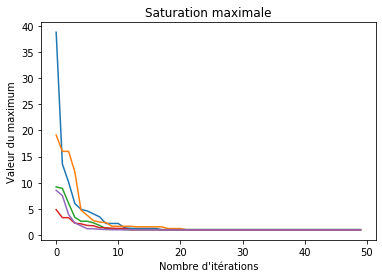

In [58]:
for delta in [5,10,20,30,40]:
    sat=routage(G,K)
    adaptation_capa(delta,sat)
    print("Optimisation des métriques pour delta =",delta)
    methode_incrementale_selection_minimum(50,True)
    

In [38]:
init_capa()
def adaptation_capa_bis(delta,sat):
    for i in G:
        for j in G[i]:
            if i<j:
                x=sat[i][j]
                if x > 0:
                    valeur = random.uniform(x*(1-delta),x*(1+delta))
                    G[i][j]['capa']=valeur

In [39]:
poids = np.zeros((n+1,n+1))
for i in range(n):
    for j in range(n):
        poids[i][j]=1


valeur du minimum 1.3336666666666668
Optimisation des métriques pour delta = 0.05



valeur du minimum 2.8086504001891934
Optimisation des métriques pour delta = 0.1



valeur du minimum 1.503724050498347
Optimisation des métriques pour delta = 0.15



valeur du minimum 2.5424045844124814
Optimisation des métriques pour delta = 0.2



valeur du minimum 2.0677125793182
Optimisation des métriques pour delta = 0.25



valeur du minimum 1.3580060494055024


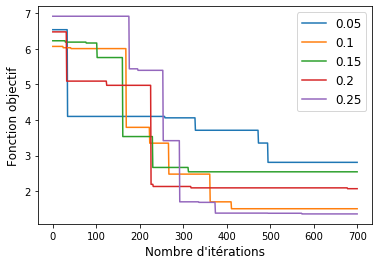

In [43]:
init_capa()
tour, best0, cseq, bseq = recuit(K,poids, N_iter,poids_voisinage, T)
mise_a_jour_poids(best0,G)

for delta in [0.05,0.1,0.15,0.2,0.25]:

    init_capa()
    mise_a_jour_poids(best0,G)
    sat=routage(G,K)
    adaptation_capa_bis(delta,sat)
    
    print("Optimisation des métriques pour delta =",delta)
    N_iter = 700
    n = len(G.nodes())

    tour, best, cseq, bseq = recuit(K,poids, N_iter,poids_voisinage, T)
    

    def plot_recuit(cseq, bseq, best, legend=True, label=""):
        #p2, = plt.plot(cseq)
        p3, = plt.plot(bseq, label=str(delta)+label)
        if legend:
            plt.legend(fontsize=12)
            plt.ylabel("Fonction objectif", fontsize=12)
            plt.xlabel("Nombre d'itérations", fontsize=12)
    plot_recuit(cseq, bseq, best)

## 8. Test avec des poids premiers


Minimum trouvé :  0.8199555555555555


(0.8199555555555555, 20)

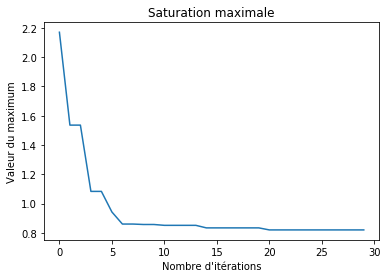

In [145]:
init_poids(G)
def modification_maximum_premiers(Graph,Kmat,sat):
    ind_max=np.unravel_index(np.argmax(sat, axis=None), sat.shape)
    imax=ind_max[0]
    jmax=ind_max[1]
    valeur = Graph[imax][jmax]['poids']
    Graph[imax][jmax]['poids']=premiers[premiers.index(valeur)+1]


def methode_incrementale_premiers(n,trace,Graph,Kmat,condition=False):
    
    liste_max=[]
    init_poids(Graph)
    sat1=cout_routage(routage(Graph,Kmat),Graph,condition)
    ind_max=np.unravel_index(np.argmax(sat1, axis=None), sat1.shape)
    i1=ind_max[0]
    j1=ind_max[1]
    J1=sat1[i1][j1] #J1 va contenir le minimum global
    sat2=sat1
    
    for k in tqdm(range(n)):
        modification_maximum_premiers(Graph,Kmat,sat2)
        sat2=cout_routage(routage(Graph,Kmat),Graph,condition)
        ind_max=np.unravel_index(np.argmax(sat2, axis=None), sat2.shape)
        i2=ind_max[0]
        j2=ind_max[1]
        J2=sat2[i2][j2]
        if (J1<J2):
            liste_max.append(J1)
        else:
            liste_max.append(J2)
            J1=J2
            
    print("Minimum trouvé : ",J1)
    
    if trace:
        plt.plot([k for k in range(n)],liste_max)
        plt.title("Saturation maximale")
        plt.xlabel("Nombre d'itérations")
        plt.ylabel("Valeur du maximum")
        
    return J1, convergence(liste_max,J1)

methode_incrementale_premiers(30,True,G,K)

## 9. Apprentissage par renforcement pour optimiser les métriques

![title](RL.jpg)
![title](Belmann.jpg)

In [4]:
import numpy as np
import keras.backend.tensorflow_backend as backend
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import tensorflow as tf
from collections import deque
import time



DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 50 # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 100  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)
MODEL_NAME = 'Routage'
MIN_REWARD = -2.75  # For model save
MEMORY_FRACTION = 0.20

SIZE=57
MAX_ITERATIONS = 50


# Environment settings
EPISODES = 700

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001

#  Stats settings
AGGREGATE_STATS_EVERY = 50  # episodes
SHOW_PREVIEW = False


# Create models folder
if not os.path.isdir('models'):
    os.makedirs('models')

In [25]:
def recompense(saturations):
    ind_max=np.unravel_index(np.argmax(saturations, axis=None), saturations.shape)
    i1=ind_max[0]
    return saturations[i1]

In [26]:
def conversion(saturations,G):
    X=[]
    compteur=0
    for i in G:
        for j in G[i]:
            if i<j:
                X.append(saturations[i,j])
    return np.array(X)

In [27]:
mapping={}
compteur=0
for i in G:
    for j in G[i]:
        mapping[compteur]=(i,j)
        compteur+=1

## L'environnement

In [35]:
class Reseau:
    def __init__(self, G, K):
        self.G = G
        self.K = K
        

    def __str__(self):

        plt.figure(figsize=(15,10));
        plt.axis('off')

        nx.draw_networkx_labels(G,pos,labels=site,font_size=10,font_color='black')
        nx.draw(G, pos=pos, node_size=500, node_color='lightgrey', edge_color='grey')

        nx.draw_networkx_labels(K,pos,labels=site,font_size=10,font_color='black')  
        nx.draw_networkx_nodes(K, pos=pos, node_size=600, node_color='orange',node_shape='s')
        return "visualisation du réseau"

    def action(self,action):
        i,j=mapping[action]
        try:
            self.G[i][j]['poids']+=1
            #print("arrete",i," ",j,"modifée")
        except:
            print("l'arrete",i," ",j,"n'existe pas")


class Routage:
    def __init__(self, res):
        self.reseau=res
        self.saturations = np.zeros((SIZE+1,SIZE+1))
        self.episode_step=0

    def reset(self):

        #for i in range(1,38):
            #for j in G[i] :
                #if i<j:
                    #self.reseau.G[i][j]['poids']=random.randint(1,10)
                    #G[i][j]['poids']=random.randint(1,10)
                    
        sat=routage(self.reseau.G,self.reseau.K)
        
        return conversion(cout_routage(sat,self.reseau.G),self.reseau.G)

    def step(self, action):
        
        self.reseau.action(action)
        self.episode_step += 1
            
        new_observation=conversion(cout_routage(routage(self.reseau.G,self.reseau.K),slef.reseau.G),self.reseau.G)
        reward = -recompense(new_observation)
        
        done=False
        
        if self.episode_step > MAX_ITERATIONS:
            done = True
        return new_observation, reward, done
    
    def get_input(self):
        return conversion(self.saturations,self.reseau.G)


res = Reseau(G,K)
env = Routage(res)
# For stats
ep_rewards = [-2.75]
# For more repetitive results
random.seed(1)
np.random.seed(1)
tf.set_random_seed(1)

In [36]:
# Agent class
class DQNAgent:
    def __init__(self):

        # Main model
        self.model = self.create_model()

        # Target network
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # An array with last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Custom tensorboard object
        self.tensorboard = ModifiedTensorBoard(log_dir="logs/{}-{}".format(MODEL_NAME, int(time.time())))

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0

    def create_model(self):
        model = Sequential()
        model.add(Dense(64,activation='relu',input_shape=(57,)))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(57, activation='relu'))
            
        model.compile(loss="mse", optimizer=Adam(lr=0.1), metrics=['accuracy'])
        
        #model.summary()
        
        return model

    # Adds step's data to a memory replay array
    # (observation space, action, reward, new observation space, done)
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    # Trains main network every step during episode
    def train(self, terminal_state, step):

        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.model.predict(current_states)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X), np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False, callbacks=[self.tensorboard] if terminal_state else None)

        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape))[0]
        #return self.model.predict(np.array(state))

Text(0, 0.5, 'Valeur du maximum')

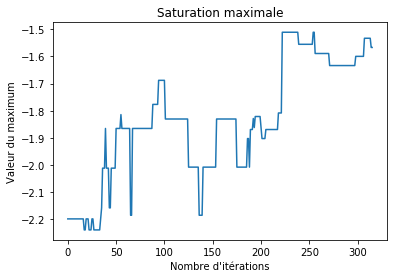

In [37]:
agent = DQNAgent()
liste_reward=[]
# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):

    min_reward=-5
    # Update tensorboard step every episode
    agent.tensorboard.step = episode

    # Restarting episode - reset episode reward and step number
    episode_reward = recompense( conversion( cout_routage( routage(env.reseau.G,env.reseau.K), env.reseau.G ),env.reseau.G ) ) 
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state))
        else:
            # Get random action
            action = np.random.randint(0, SIZE)

        new_state, reward, done = env.step(action)
        
        if reward>=min_reward:
            min_reward=reward
            liste_reward.append(reward)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        #if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            #env.render()

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)

        current_state = new_state
        step += 1

    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)

        # Save model, but only when min reward is greater or equal a set value
        if min_reward >= MIN_REWARD:
            agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.model')

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)
        
        
plt.plot([k for k in range(len(liste_reward))],liste_reward)
plt.title("Saturation maximale")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Valeur du maximum")

In [ ]:
G2=env.reseau.G
K2=env.reseau.K
sat=routage(G2,K2)    
print(recompense(cout_routage(sat),env.reseau.G))

In [ ]:
X=[]
for i in range(20):
    X.append(liste_reward[i])
plt.plot([k for k in range(len(X))],X)
plt.title("Saturation maximale")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Valeur du maximum")

In [30]:
class ModifiedTensorBoard(TensorBoard):

    # Overriding init to set initial step and writer (we want one log file for all .fit() calls)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        self.writer = tf.summary.FileWriter(self.log_dir)

    # Overriding this method to stop creating default log writer
    def set_model(self, model):
        pass

    # Overrided, saves logs with our step number
    # (otherwise every .fit() will start writing from 0th step)
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    # Overrided
    # We train for one batch only, no need to save anything at epoch end
    def on_batch_end(self, batch, logs=None):
        pass

    # Overrided, so won't close writer
    def on_train_end(self, _):
        pass

    # Custom method for saving own metrics
    # Creates writer, writes custom metrics and closes writer
    def update_stats(self, **stats):
        self._write_logs(stats, self.step)

## Annexe 1 : première version du calcul du routage

In [ ]:
def mise_a_jour(alpha,visualise,PCC):
    
    pas_termine=False
    n=len(G.nodes())
    saturations=np.zeros((n+1,n+1)) #on rajoute un indice pour faire correspondre l'indice i au noeud i (pour la lisibilité du code)

    for noeud in range(1,n+1):

        liste_attente = routage[noeud][0] 

        a_supprimer=[] #cette liste va contenir tout ce que l'on devra supprimer de la liste d'attente
    
        for k in range(len(liste_attente)): 

            x=liste_attente[k]
  
            if (x[1]!=noeud): #Si on n'est pas encore arrivé à destination
                pas_termine=True
                destinations=PCC[x[0]][x[1]][noeud]  #on utilise la matrice PCC des plus courts chemins calculée dans la section précédente.
                charge=x[2]/len(destinations)
    

                for dest in destinations:


                    if saturations[noeud][dest]<alpha*G[noeud][dest]['capa']: #Si on peut encore faire passer de l'info
       
                        disponible = alpha*G[noeud][dest]['capa']-saturations[noeud][dest] #on a donc disponible > 0, c'est la quantité d'info qu'on peut transmettre sur l'arrete
                        restant = max(0,charge-disponible) # disponible + restant = charge
     

                        if (disponible<charge): #si on ne peut pas tout faire passer 
                            x[2]-=disponible
                            routage[dest][1].append([x[0],x[1],disponible])
                            saturations[noeud][dest]+=disponible
             
                        if (disponible>=charge):
      
                            x[2]-=charge
                            x_transmis = [x[0],x[1],charge]
                            routage[dest][1].append(x_transmis)
                            saturations[noeud][dest]+=charge   

            else :
                a_supprimer.append(x)

        for x in liste_attente:
            if x[2]<eps:
                a_supprimer.append(x)

        for x in a_supprimer:
            routage[noeud][0].remove(x)

    #on prépare maintenant l'étape suivante (remise à [] de la liste entrants)
    for noeud in range(1,n+1):
        routage[noeud][0]=routage[noeud][0]+routage[noeud][1]  
        routage[noeud][1]=[]

    if visualise:
 
        edge_lab={}
        for (u,v) in G.edges():
            edge_lab[(u,v)] = round(10*(saturations[u,v]+saturations[v,u]))/10
    

        plt.figure(figsize=(15,10));
        plt.axis('off')

        nx.draw_networkx_labels(G,pos,font_size=10,font_color='black')
        nx.draw(G, pos=pos,node_size=500, node_color='lightgrey', edge_color='grey')

        nx.draw_networkx_labels(K,pos,font_size=10,font_color='black')  
        nx.draw_networkx_nodes(K, pos=pos, node_size=600, node_color='orange',node_shape='s')
        nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_lab,font_color='red',font_size=10)
        print(edge_lab)

    return (pas_termine)

## Annexe 2 : réalisation du crible d'Erathostène

In [135]:
def eratosthene(n):
    if n<2:
        return []
    n += 1
    tableau = [False,False] + [True]*(n-2)
    tableau[2::2] = [False]*((n-2)//2 + n%2) 
    premiers = [2] 
    racine = int(n**0.5)
    racine = racine + [1,0][racine%2] 
    for i in range(3, racine+1, 2):
        if tableau[i]:
            premiers.append(i)
            tableau[i::i] = [False]*((n-i)//i + int((n-i)%i>0)) 
    for i in range(racine, n, 2):
        if tableau[i]:
            premiers.append(i)
    return premiers

## Annexe 3 : comment dessiner un graphe

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(15,10));
plt.axis('off')

nx.draw_networkx_labels(G,pos,labels=site,font_size=10,font_color='black')
nx.draw(G, pos=pos, node_size=500, node_color='lightgrey', edge_color='grey')

nx.draw_networkx_labels(K,pos,labels=site,font_size=10,font_color='black')  .

nx.draw_networkx_nodes(K, pos=pos, node_size=600, node_color='orange',node_shape='s')